# Personalized Learning Pathway Recommendation System For Post_secondary Somali Learners Using Collaborative Filtering (CF)


### Step 1: Import Libraries 

In [89]:
# ================================================
# Step 1: Importing Required Libraries
# ================================================

# Data Handling
import pandas as pd
import numpy as np

# Data Visualization (optional for analysis)
import matplotlib.pyplot as plt
import seaborn as sns

# Recommendation Model Libraries
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy

# Encoding & Utilities
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

# Suppress warnings for clean output
import warnings
warnings.filterwarnings('ignore')

import os

In [91]:
print(os.getcwd())

C:\Users\HP


In [165]:
# ================================================
# Step 1: Load Datasets
# ================================================

# Load real course metadata
courses_df = pd.read_csv('Courses_and_Learning_Material.csv')

# Load real course listing (used to simulate interactions)
raw_courses_df = pd.read_csv('Learning_Pathway_Index.csv')

# ================================================
# Step 2: Rename Columns for Consistency
# ================================================

courses_df.rename(columns={'Module_Code': 'course_id'}, inplace=True)
raw_courses_df.rename(columns={'Module_Code': 'course_id'}, inplace=True)

# ================================================
# Step 3: Simulate User-Course Interactions
# ================================================

# Extract unique course_ids
course_ids = raw_courses_df['course_id'].unique()

# Simulate 100 fake users (user_id 1 to 100)
user_ids = range(1, 101)

# Generate random interactions
np.random.seed(42)  # For reproducibility
simulated_data = []

for user in user_ids:
    sampled_courses = np.random.choice(course_ids, size=np.random.randint(5, 15), replace=False)
    for course in sampled_courses:
        rating = np.random.choice([0.6, 0.8, 1.0])
        simulated_data.append((user, course, rating))

# Create DataFrame
cf_data = pd.DataFrame(simulated_data, columns=['user_id', 'course_id', 'rating'])

# ================================================
# Step 4: Preview and Confirm
# ================================================

print("✅ Interaction Dataset Shape:", cf_data.shape)
print("✅ Sample Interaction Data:")
display(cf_data.head())

print("\n✅ Course Metadata Shape:", courses_df.shape)
print("✅ Sample Course Data:")
display(courses_df.head())


✅ Interaction Dataset Shape: (955, 3)
✅ Sample Interaction Data:


,user_id,course_id,rating
0,1,CLMML09,0.6
1,1,CLMGA02,0.6
2,1,CLMML10,0.6
3,1,CLMML03,1.0
4,1,CLMML00,1.0



✅ Course Metadata Shape: (34, 9)
✅ Sample Course Data:


,course_id,Source,Course_Level,Duration,Prerequisites,Prework,Course_Learning_Material,Course_Learning_Material_Link,Type_Free_Paid
0,CLMML00,Google Developers,Beginners,70 minutes,No,No,Introduction to Machine Learning,https://developers.google.com/machine-learning...,Free
1,CLMML01,Google Developers,Beginners to Intermediate,NaN,"Yes, a handful",Yes,Machine Learning Crash Course (Foundation),https://developers.google.com/machine-learning...,Free
2,CLMML02,Google Developers,Beginners to Intermediate,45 minutes,No,No,Problem Framing (ML related),https://developers.google.com/machine-learning...,Free
3,CLMML03,Google Developers,Beginners to Intermediate,NaN,No,No,Data Preparation and Feature Engineering in ML,https://developers.google.com/machine-learning...,Free
4,CLMML04,Google Developers,Beginners to Intermediate,NaN,Yes,No,Testing and Debugging,https://developers.google.com/machine-learning...,Free


### Step 3: Preprocessing and Simulating Interactions

In [171]:
# ================================================
# ✅ Step 3: Data Preprocessing for CF Model
# - Simulate user-course interactions
# - Prepare dataset for training Collaborative Filtering
# ================================================

# 🔹 Load the raw interaction dataset
interaction_df = pd.read_csv('Learning_Pathway_Index.csv')

# 🔹 Extract unique course/module IDs
course_ids = interaction_df['Module_Code'].unique()

# 🔹 Simulate 100 users (IDs 1 to 100)
user_ids = range(1, 101)

# 🔹 Generate synthetic ratings (simulating engagement)
# - 1.0 = highly engaged
# - 0.8 = moderately engaged
# - 0.6 = low engagement
np.random.seed(42)  # For reproducibility
simulated_data = []

for user in user_ids:
    sampled_courses = np.random.choice(course_ids, size=np.random.randint(5, 15), replace=False)
    for course in sampled_courses:
        rating = np.random.choice([0.6, 0.8, 1.0])
        simulated_data.append((user, course, rating))

# 🔹 Create a DataFrame for the simulated CF data
cf_data = pd.DataFrame(simulated_data, columns=['user_id', 'course_id', 'rating'])

# ✅ Optional: Ensure course_id is string (for Surprise compatibility)
cf_data['course_id'] = cf_data['course_id'].astype(str)

# ✅ Preview the final preprocessed dataset
print("✅ Collaborative Filtering Dataset is ready:")
display(cf_data.head())


✅ Collaborative Filtering Dataset is ready:


,user_id,course_id,rating
0,1,CLMML09,0.6
1,1,CLMGA02,0.6
2,1,CLMML10,0.6
3,1,CLMML03,1.0
4,1,CLMML00,1.0


In [98]:
# Check the structure and completeness
print("\n🔍 Shape of Interaction Data:", interaction_df.shape)
print("🔍 Shape of Course Metadata:", courses_df.shape)


🔍 Shape of Interaction Data: (1382, 10)
🔍 Shape of Course Metadata: (34, 9)


In [169]:
print("\n📊 Info - Interaction Data:")
interaction_df.info()


📊 Info - Interaction Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Module_Code                                1382 non-null   object
 1   Course_Learning_Material                   1382 non-null   object
 2   Source                                     1382 non-null   object
 3   Course_Level                               1382 non-null   object
 4   Type_Free_Paid                             1382 non-null   object
 5   Module                                     1382 non-null   object
 6   Duration                                   1321 non-null   object
 7   Difficulty_Level                           1381 non-null   object
 8   Keywords_Tags_Skills_Interests_Categories  1382 non-null   object
 9   Links                                      1373 non-null   object
dtypes: objec

### Step 4: Feaure Encoding

In [184]:
# ================================================
# ✅ Step 4: Model Preparation
# ================================================

from surprise import Dataset, Reader

# 🔹 Prepare only the necessary columns 
cf_data_for_surprise = cf_data[['user_id', 'course_id', 'rating']]

# 🔹 Setup Surprise Reader
reader = Reader(rating_scale=(0.6, 1.0))

# 🔹 Load data into Surprise
data = Dataset.load_from_df(cf_data_for_surprise, reader)

# ✅ Preview
print("🎯 Data ready for training.")
cf_data_for_surprise.head()


🎯 Data ready for training.


,user_id,course_id,rating
0,1,CLMML09,0.6
1,1,CLMGA02,0.6
2,1,CLMML10,0.6
3,1,CLMML03,1.0
4,1,CLMML00,1.0


### Step 5: Exploratory Data Analysis (EDA)

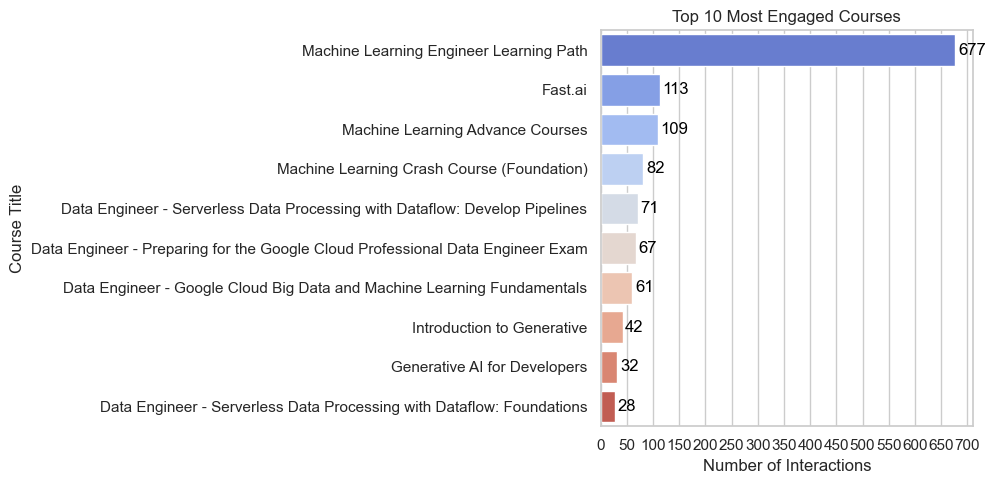

In [187]:
# Set a consistent style
sns.set(style='whitegrid')

# Top 10 Most Popular Courses
top_courses = interaction_df['Course_Learning_Material'].value_counts().head(10)

plt.figure(figsize=(10,5))
ax = sns.barplot(y=top_courses.index, x=top_courses.values, palette='coolwarm')

# Add value labels
for i, v in enumerate(top_courses.values):
    ax.text(v + 5, i, str(v), color='black', va='center')

plt.title("Top 10 Most Engaged Courses")
plt.xlabel("Number of Interactions")
plt.ylabel("Course Title")
plt.xticks(ticks=range(0, max(top_courses.values) + 50, 50))
plt.tight_layout()
plt.show()


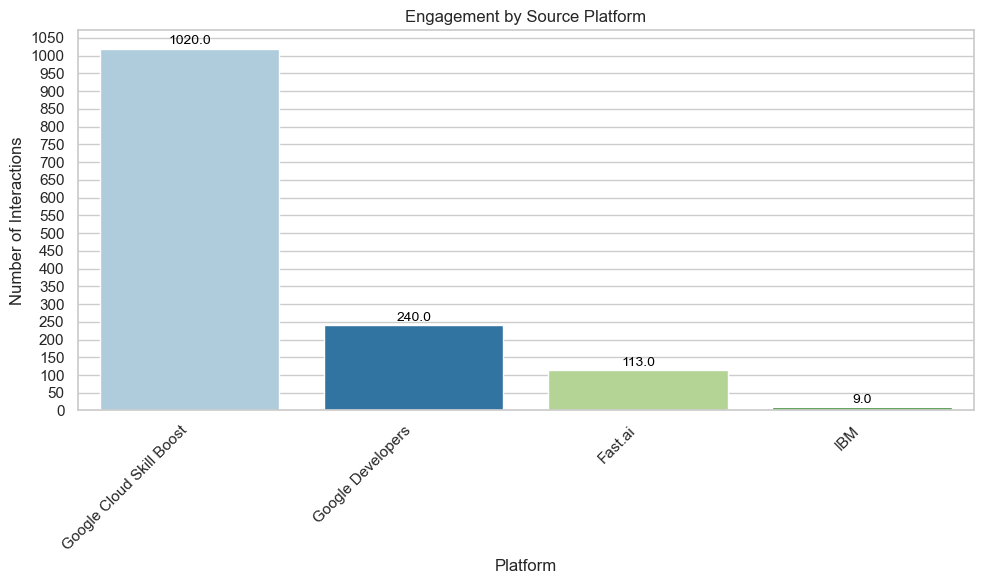

In [110]:
# ==============================
# Figure 2: Engagement by Source Platform
# ==============================
plt.figure(figsize=(10, 6))
source_order = interaction_df['Source'].value_counts()
ax = sns.countplot(data=interaction_df, x='Source', palette='Paired', order=source_order.index)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height + 5), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.title("Engagement by Source Platform")
plt.xlabel("Platform")
plt.ylabel("Number of Interactions")
plt.xticks(rotation=45, ha='right')
plt.yticks(ticks=range(0, max(source_order.values) + 50, 50))
plt.tight_layout()
plt.show()

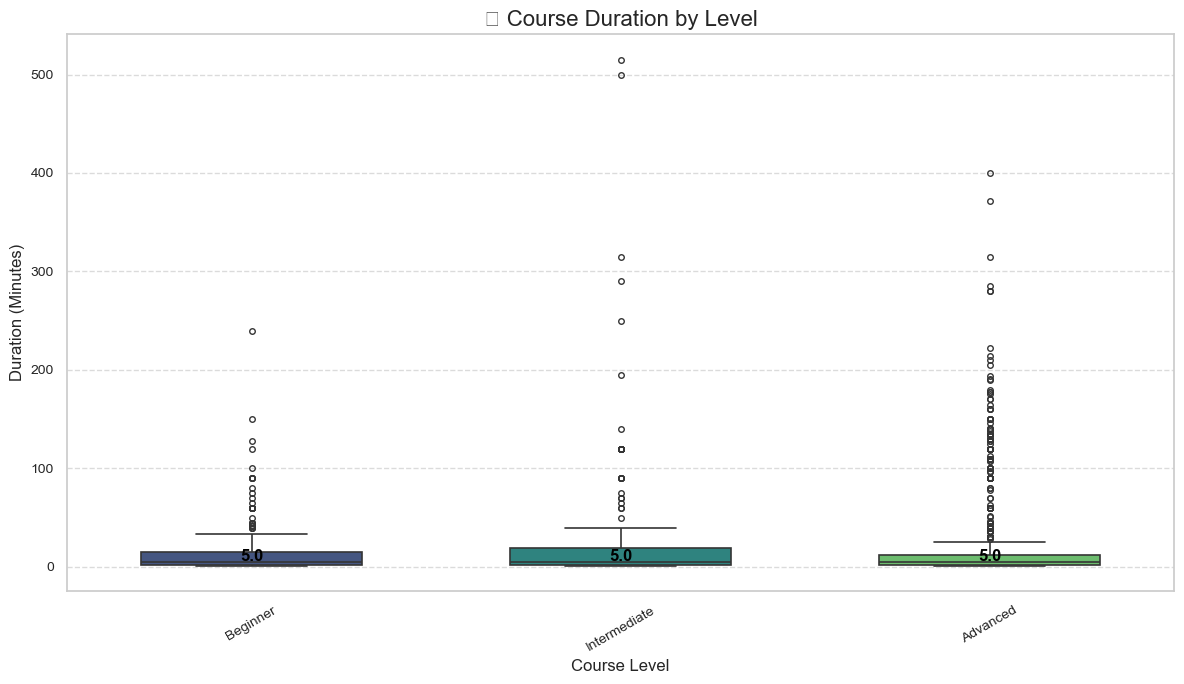

In [191]:
# ================================================
# 💡 Course Duration Analysis by Course Level (Beautified)
# ================================================

# Ensure 'Duration' is a string for extraction
interaction_df['Duration'] = interaction_df['Duration'].astype(str)

# Extract numeric part (e.g., '20.0' from '20.0 minutes')
interaction_df['Duration_cleaned'] = interaction_df['Duration'].str.extract(r'(\d+(?:\.\d+)?)').astype(float)

# Optional: Drop NaNs (if any missing durations were extracted)
interaction_df = interaction_df.dropna(subset=['Duration_cleaned'])

# Plot improved boxplot
plt.figure(figsize=(12, 7))
ax = sns.boxplot(
    data=interaction_df,
    x='Course_Level',
    y='Duration_cleaned',
    palette='viridis',
    width=0.6,                  # Slightly thinner boxes
    linewidth=1.2,              # Sharper box edges
    fliersize=4                 # Smaller outlier points
)

# Improve readability
plt.title("💡 Course Duration by Level", fontsize=16)
plt.xlabel("Course Level", fontsize=12)
plt.ylabel("Duration (Minutes)", fontsize=12)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display exact median on top of each box
medians = interaction_df.groupby("Course_Level")["Duration_cleaned"].median()
for tick, median in zip(ax.get_xticks(), medians):
    ax.text(tick, median + 1, f'{median:.1f}', 
            horizontalalignment='center', fontweight='bold', color='black')

plt.tight_layout()
plt.show()


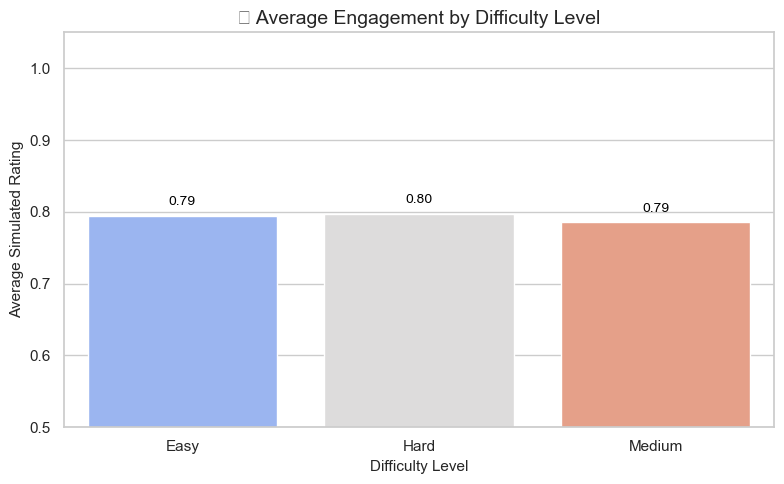

In [202]:
# ================================================
# 🧠 Average Engagement by Difficulty Level (Polished)
# ================================================

# 🔗 Merge cf_data with Difficulty_Level info (ensure uniqueness)
difficulty_info = interaction_df[['Module_Code', 'Difficulty_Level']].drop_duplicates()
cf_merged = cf_data.merge(difficulty_info, left_on='course_id', right_on='Module_Code', how='left')

# 🧮 Group and calculate average engagement by difficulty
avg_engagement = cf_merged.groupby('Difficulty_Level')['rating'].mean().reset_index()

# 📊 Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=avg_engagement, x='Difficulty_Level', y='rating', palette='coolwarm')

# 🏷️ Annotate values on bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', 
                (p.get_x() + p.get_width() / 2., height + 0.01), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.title("🧠 Average Engagement by Difficulty Level", fontsize=14)
plt.xlabel("Difficulty Level", fontsize=11)
plt.ylabel("Average Simulated Rating", fontsize=11)
plt.ylim(0.5, 1.05)
plt.tight_layout()
plt.show()


### Step 5: Train & Evaluate Collaborative Filtering Model

In [204]:
# ================================================
# ✅ Step 5: Train & Evaluate Collaborative Filtering Model
# Using SVD from Surprise
# ================================================

from surprise import SVD, accuracy
from surprise.model_selection import train_test_split

# Split data into training and test sets (80/20)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Initialize the SVD model
svd_model = SVD(n_factors=50, biased=True, random_state=42)

# Train the model on the training set
svd_model.fit(trainset)

# Make predictions on the test set
predictions = svd_model.test(testset)

# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"\n✅ Model Evaluation Complete:")
print(f"📉 RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"📊 MAE  (Mean Absolute Error): {mae:.4f}")


RMSE: 0.1786
MAE:  0.1499

✅ Model Evaluation Complete:
📉 RMSE (Root Mean Squared Error): 0.1786
📊 MAE  (Mean Absolute Error): 0.1499


### Step 6: Personalized Course Recommendation Function

In [206]:
# ================================================
# ✅ Step 6: Personalized Course Recommendation Function
# ================================================

def get_top_recommendations(user_id, n=5):
    # All course IDs
    all_course_ids = cf_data['course_id'].unique()

    # Courses already interacted with
    user_history = cf_data[cf_data['user_id'] == user_id]['course_id'].unique()

    # Predict unseen course ratings
    unseen_courses = [course for course in all_course_ids if course not in user_history]
    predictions = []

    for course in unseen_courses:
        pred = svd_model.predict(user_id, course)
        predictions.append((course, pred.est))

    # Sort by predicted score
    sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)

    # Build top N DataFrame
    top_courses = pd.DataFrame(sorted_predictions[:n], columns=['course_id', 'predicted_rating'])

    # Merge with metadata
    top_courses = top_courses.merge(courses_df, on='course_id', how='left')

    return top_courses[['course_id', 'Course_Learning_Material', 'Course_Level', 'Source', 'predicted_rating']]

# 🎯 Example usage:
user_id = 10
recommended_courses = get_top_recommendations(user_id=user_id, n=5)
display(recommended_courses)


,course_id,Course_Learning_Material,Course_Level,Source,predicted_rating
0,CLMAIE1,AI Ethics Resources,Beginners to Intermediate,IBM,0.893440
1,CLMML06,Recommendation Systems,Intermediate to Advanced,Google Developers,0.880019
2,CLMML12,Machine Learning Advance Courses,Intermediate to Advanced,Google Developers,0.841768
3,CLMML02,Problem Framing (ML related),Beginners to Intermediate,Google Developers,0.829699
4,CLMF001,Fast.ai,Intermediate to Advanced,Fast.ai,0.829052


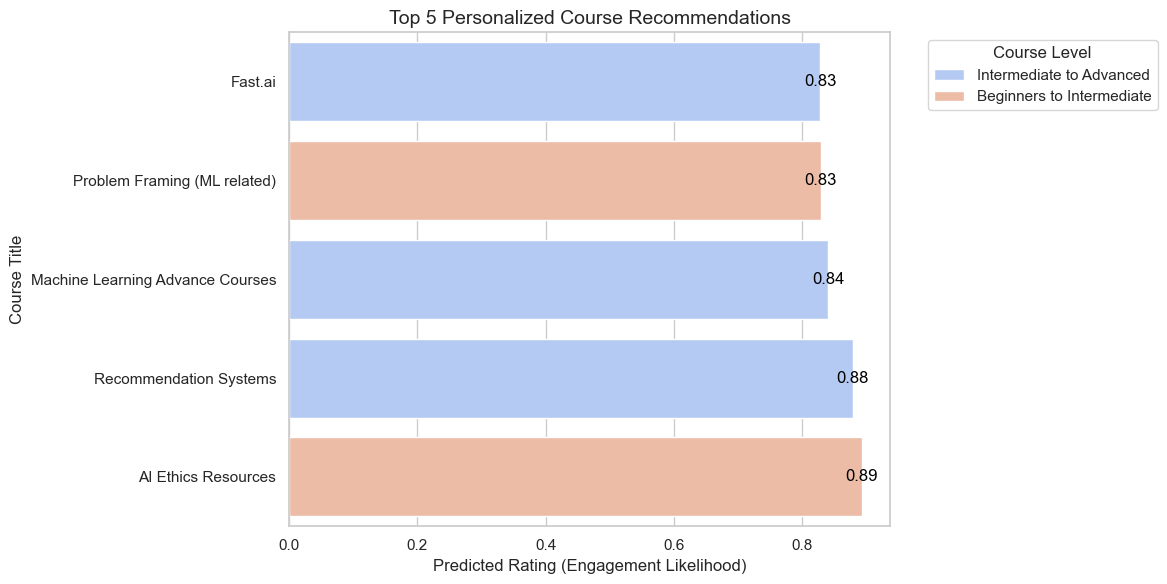

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Step 7: Sort by predicted rating for clean visuals
recommended_courses = recommended_courses.sort_values(by='predicted_rating', ascending=True)

# Set plot style
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))

# Create barplot
sns.barplot(
    data=recommended_courses,
    x='predicted_rating',
    y='Course_Learning_Material',
    hue='Course_Level',
    palette='coolwarm'
)

# Add labels and title
plt.title("Top 5 Personalized Course Recommendations", fontsize=14)
plt.xlabel("Predicted Rating (Engagement Likelihood)", fontsize=12)
plt.ylabel("Course Title", fontsize=12)
plt.legend(title='Course Level', bbox_to_anchor=(1.05, 1), loc='upper left')

# Optional: Add data labels on top of bars
for index, value in enumerate(recommended_courses['predicted_rating']):
    plt.text(value, index, f'{value:.2f}', color='black', ha='center', va='center')

# Improve layout and prevent clipping
plt.tight_layout()
plt.show()


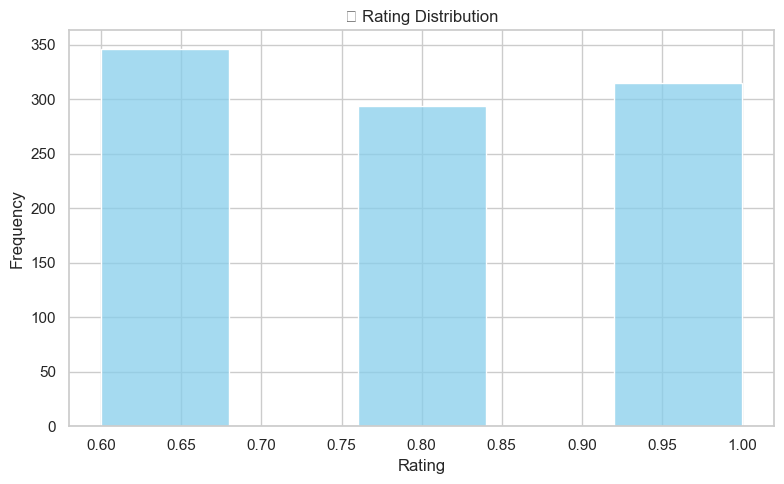

In [234]:
# =========================================
# 📊 Figure 1: Rating Distribution
# =========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load and simulate user-course interaction data
pathway_df = pd.read_csv('Learning_Pathway_Index.csv')
user_ids = range(1, 101)
course_ids = pathway_df['Module_Code'].unique()

np.random.seed(42)
ratings_data = []

for user in user_ids:
    sampled_courses = np.random.choice(course_ids, size=np.random.randint(5, 15), replace=False)
    for course in sampled_courses:
        rating = np.random.choice([0.6, 0.8, 1.0])
        ratings_data.append((user, course, rating))

cf_data = pd.DataFrame(ratings_data, columns=['user_id', 'course_id', 'rating'])

# Plot: Rating distribution
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.histplot(cf_data['rating'], bins=5, kde=False, color='skyblue')
plt.title("📊 Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


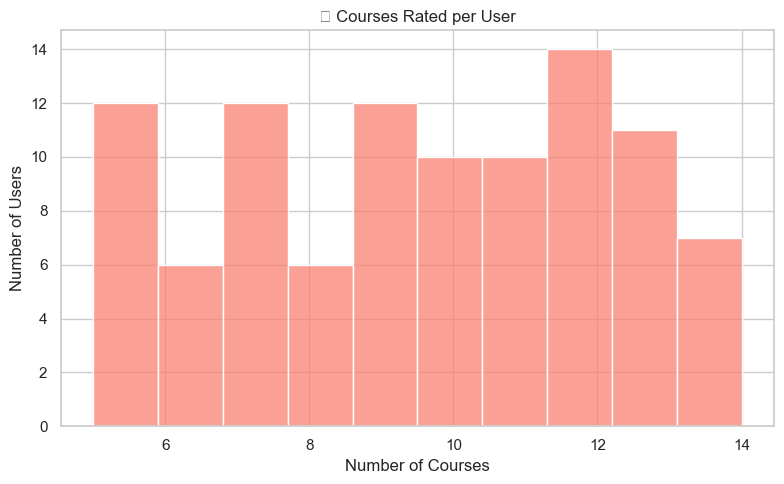

In [236]:
# =========================================
# 📊 Figure 2: Courses Rated per User
# =========================================

course_per_user = cf_data.groupby('user_id')['course_id'].count()

plt.figure(figsize=(8, 5))
sns.histplot(course_per_user, bins=10, color='salmon')
plt.title("📊 Courses Rated per User")
plt.xlabel("Number of Courses")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()


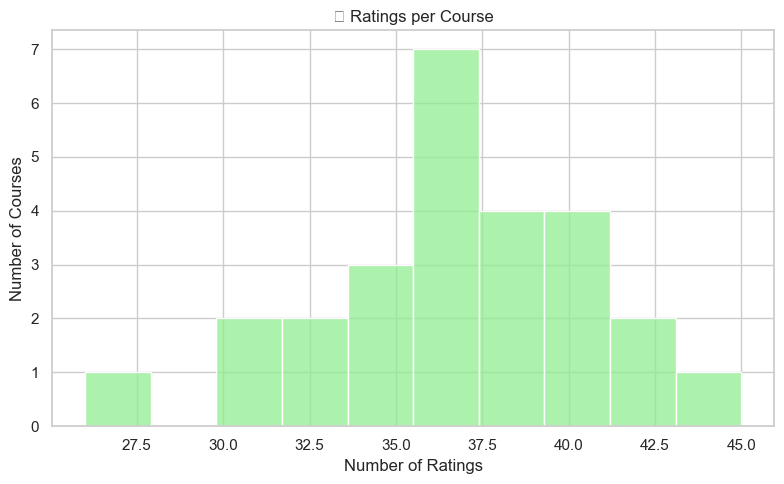

In [238]:
# =========================================
# 📊 Figure 3: Ratings per Course
# =========================================

ratings_per_course = cf_data.groupby('course_id')['rating'].count()

plt.figure(figsize=(8, 5))
sns.histplot(ratings_per_course, bins=10, color='lightgreen')
plt.title("📊 Ratings per Course")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Courses")
plt.tight_layout()
plt.show()


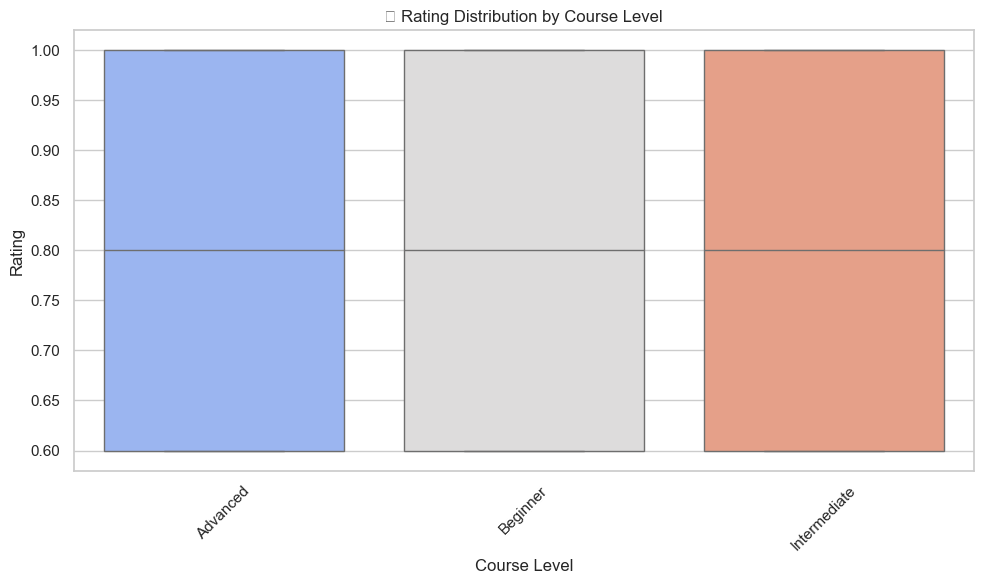

In [240]:
# =========================================
# 📊 Figure 4: Rating Distribution by Course Level
# =========================================

if 'Course_Level' in pathway_df.columns:
    merged_df = cf_data.merge(
        pathway_df[['Module_Code', 'Course_Level']],
        left_on='course_id',
        right_on='Module_Code',
        how='left'
    )

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=merged_df, x='Course_Level', y='rating', palette='coolwarm')
    plt.title("📊 Rating Distribution by Course Level")
    plt.xlabel("Course Level")
    plt.ylabel("Rating")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 'Course_Level' column not available in dataset.")


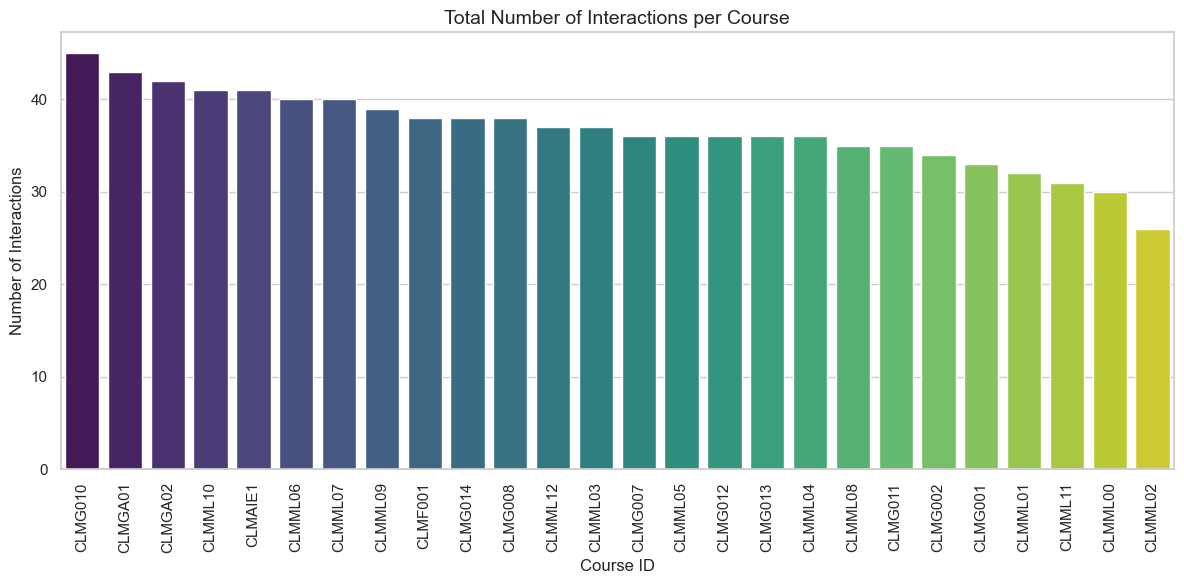

In [242]:
# Total Interactions per Course
# ================================================

# Count interactions per course
course_interactions = cf_data['course_id'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=course_interactions.index, y=course_interactions.values, palette='viridis')

# Add labels and title
plt.title("Total Number of Interactions per Course", fontsize=14)
plt.xlabel("Course ID", fontsize=12)
plt.ylabel("Number of Interactions", fontsize=12)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()


In [244]:
# ================================================
# ✅ Step 8: Save Model and Metadata for Deployment
# ================================================

import os
import pickle
import pandas as pd

# Create a folder to store model files
os.makedirs("models", exist_ok=True)

# Save the trained SVD model
with open("models/svd_model.pkl", "wb") as f:
    pickle.dump(svd_model, f)

# Save the course metadata
courses_df.to_csv("models/courses_metadata.csv", index=False)

# Optional: Save simulated interaction data if needed later
cf_data.to_csv("models/simulated_interactions.csv", index=False)

print("✅ Model, metadata, and interaction data saved successfully.")


# ================================================
# ✅ Step 9: Load Model and Metadata (Anytime Later)
# ================================================

# Load model
with open("models/svd_model.pkl", "rb") as f:
    svd_model = pickle.load(f)

# Load metadata
courses_df = pd.read_csv("models/courses_metadata.csv")
cf_data = pd.read_csv("models/simulated_interactions.csv")

print("✅ Model and metadata loaded successfully.")


# ================================================
# ✅ Step 10: Recommendation Function (Ready for API)
# ================================================

def get_top_recommendations(user_id, n=5):
    all_course_ids = cf_data['course_id'].unique()
    user_history = cf_data[cf_data['user_id'] == user_id]['course_id'].unique()

    unseen_courses = [course for course in all_course_ids if course not in user_history]
    predictions = [
        (course, svd_model.predict(user_id, course).est)
        for course in unseen_courses
    ]

    sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
    top_courses = pd.DataFrame(sorted_predictions[:n], columns=['course_id', 'predicted_rating'])
    top_courses = top_courses.merge(courses_df, on='course_id', how='left')

    return top_courses[['course_id', 'Course_Learning_Material', 'Course_Level', 'Source', 'predicted_rating']]


# ================================================
# 🎯 Example Usage
# ================================================

user_id = 10
recommended = get_top_recommendations(user_id, n=5)
display(recommended)


✅ Model, metadata, and interaction data saved successfully.
✅ Model and metadata loaded successfully.


,course_id,Course_Learning_Material,Course_Level,Source,predicted_rating
0,CLMAIE1,AI Ethics Resources,Beginners to Intermediate,IBM,0.893440
1,CLMML06,Recommendation Systems,Intermediate to Advanced,Google Developers,0.880019
2,CLMML12,Machine Learning Advance Courses,Intermediate to Advanced,Google Developers,0.841768
3,CLMML02,Problem Framing (ML related),Beginners to Intermediate,Google Developers,0.829699
4,CLMF001,Fast.ai,Intermediate to Advanced,Fast.ai,0.829052
